# FLOW: Network Construction and Analysis (Chemnitz)
## Imports and Settings

In [1]:
%matplotlib inline

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
#import collections
import numpy as np
#import datetime
#import matplotlib.dates as mdates
#from matplotlib.ticker import MaxNLocator

In [3]:
warnings.filterwarnings('ignore')

In [4]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Helper Functions

## Data Model
Data generated by users $u$ is modeled as a network with resting points $v$ as nodes and ways $e$ as directed edges. Chains of ways amount to tracks $f$. Tracks originate and terminate at resting points where a user rests for at least 30 minutes ("große Ruhe"). Resting points where users rest for less than 30 minutes ("kleine Ruhe") connect ways into tracks.

## Network Construction
### Load Data

In [73]:
points = pd.read_csv('../data/points_coordinates_dec4.txt', delimiter = '\t') # dec4: 11.1m resolution

In [74]:
points.head()

,id,coordinate_x,coordinate_y
0,0,12.9735,50.9858
1,1,12.9731,50.9865
2,2,12.9704,50.9869
3,3,12.9727,50.9864
4,4,12.9704,50.9863


### Plot Data

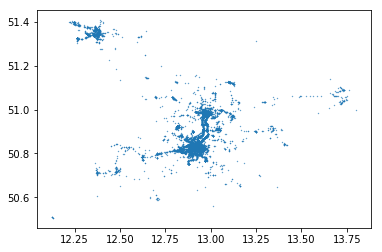

In [80]:
plt.scatter(points['coordinate_x'], points['coordinate_y'], s=0.1)

(50.834337999999995, 50.844338)

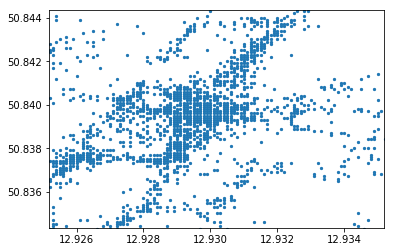

In [93]:
# chemnitz hbf (1,111m x 1,111m)
plt.scatter(points['coordinate_x'], points['coordinate_y'], s=5)
plt.xlim([12.930177-0.005, 12.930177+0.005])
plt.ylim([50.839338-0.005, 50.839338+0.005])

### Pre-Clustering

In [76]:
X = np.array(points[['coordinate_x', 'coordinate_y']])

KMeans:

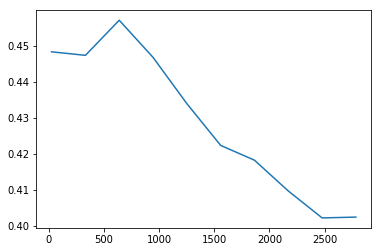

In [77]:
from sklearn import metrics
ks = [int(x) for x in np.linspace(len(points)/1000, len(points)/10, 10)]
scores = []
#for k in ks:
    clust = KMeans(n_clusters=k)
    y = clust.fit_predict(X)
    scores.append(metrics.silhouette_score(X, y, metric='euclidean'))
plt.plot(ks, scores) # ks = [27, 334, 640, 946, 1253, 1559, 1865, 2172, 2478, 2784], scores = [0.44826474486286522, 0.44728739952828722, 0.4570146706187701, 0.44673683765221017, 0.43388691422604725, 0.42232210886724414, 0.41822739969539546, 0.40967978789970338, 0.40222281228565676, 0.40244896927522189]

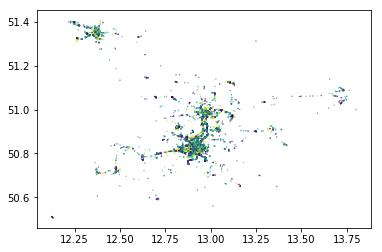

In [87]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=640)
y_km = clust.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_km, s=0.1)

(50.834337999999995, 50.844338)

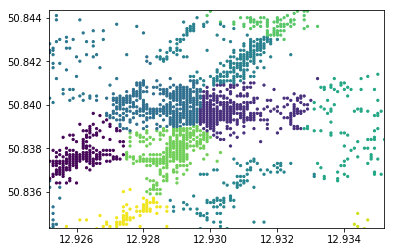

In [94]:
# chemnitz hbf (1,111m x 1,111m)
plt.scatter(X[:, 0], X[:, 1], c=y_km, s=5)
plt.xlim([12.930177-0.005, 12.930177+0.005])
plt.ylim([50.839338-0.005, 50.839338+0.005])

AgglomerativeClustering:

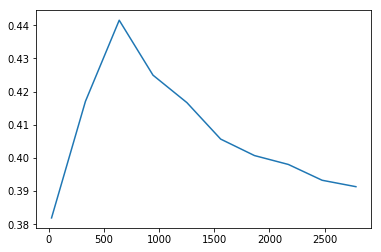

In [202]:
from sklearn import metrics
ks = [int(x) for x in np.linspace(len(points)/1000, len(points)/10, 10)]
scores = []
#for k in ks:
    clust = AgglomerativeClustering(n_clusters=k)
    y = clust.fit_predict(X)
    scores.append(metrics.silhouette_score(X, y, metric='euclidean'))
plt.plot(ks, scores) # ks = [27, 334, 640, 946, 1253, 1559, 1865, 2172, 2478, 2784], scores = [0.38190157579857764, 0.41704840758837874, 0.44150944021641519, 0.42494587837889602, 0.41667162659825052, 0.4056697713705979, 0.40070504415511077, 0.39802331107863581, 0.39325657946358872, 0.39131994659543112]

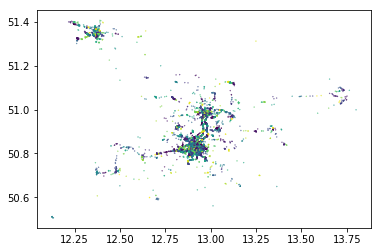

In [205]:
from sklearn.cluster import AgglomerativeClustering
clust = AgglomerativeClustering(n_clusters=640)
y_ac = clust.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_ac, s=0.1)

(50.834337999999995, 50.844338)

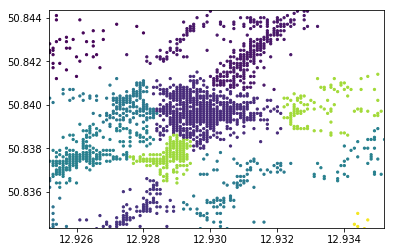

In [214]:
# chemnitz hbf (1,111m x 1,111m)
plt.scatter(X[:, 0], X[:, 1], c=y_ac, s=5)
plt.xlim([12.930177-0.005, 12.930177+0.005])
plt.ylim([50.839338-0.005, 50.839338+0.005])

DBScan:

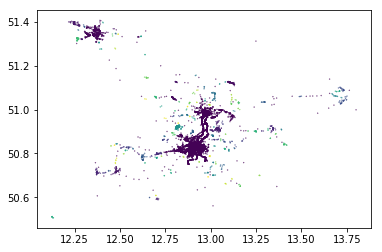

In [196]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(eps=0.01, min_samples=2)
y_dbs = clust.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_dbs, s=0.1)

(50.834337999999995, 50.844338)

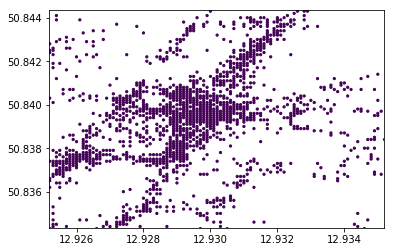

In [197]:
# chemnitz hbf (1,111m x 1,111m)
plt.scatter(X[:, 0], X[:, 1], c=y_dbs, s=5)
plt.xlim([12.930177-0.005, 12.930177+0.005])
plt.ylim([50.839338-0.005, 50.839338+0.005])

(50.707, 50.717000000000006)

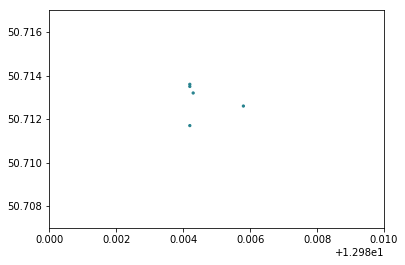

In [198]:
# ? (1,111m x 1,111m)
plt.scatter(X[:, 0], X[:, 1], c=y_dbs, s=5)
plt.xlim([12.985-0.005, 12.985+0.005])
plt.ylim([50.712-0.005, 50.712+0.005])